In [1]:
import torch
from tqdm.notebook import tqdm
import numpy as np
from transformer.reimei import ReiMei, ReiMeiParameters
import matplotlib.pyplot as plt
from config import AE_CHANNELS, DIT_S as DIT, MODELS_DIR_BASE, SIGLIP_HF_NAME, SIGLIP_EMBED_DIM
from torch.amp import autocast
from transformers import SiglipTokenizer, SiglipTextModel
from diffusers import AutoencoderDC
import time
import torchvision
from torchvision.transforms import ToPILImage

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [2]:
torch.set_grad_enabled(False)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
embed_dim = 3072
patch_size = (1,1)

params = ReiMeiParameters(
    use_mmdit=True,
    use_ec=True,
    use_moe=None,
    shared_mod=True,
    shared_attn_projs=True,
    channels=AE_CHANNELS,
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_layers=24,
    num_heads=(embed_dim // 128),
    siglip_dim=SIGLIP_EMBED_DIM,
    num_experts=4,
    capacity_factor=2.0,
    shared_experts=1,
    dropout=0.1,
    token_mixer_layers=1,
    image_text_expert_ratio=2,
)
DTYPE = torch.bfloat16

In [6]:
model = ReiMei(params)
model.load_state_dict(torch.load("models/reimei_10.pt")['model_state_dict'])

<All keys matched successfully>

In [7]:
# Print the number of parameters in the model
print("Number of parameters in the model: ", sum(p.numel() for p in model.parameters()))


Number of parameters in the model:  1414251688


In [8]:
siglip_model = SiglipTextModel.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip").to(device)
siglip_tokenizer = SiglipTokenizer.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip")

In [9]:
# prompts = [
#     "a field of grass"
# ] * 9

In [10]:
# s_tokens = siglip_tokenizer(prompts, padding='longest', truncation=True, return_tensors="pt", max_length=64).to(device)
# siglip_outputs = siglip_model(**s_tokens, output_hidden_states=True)
# siglip_embeddings = siglip_outputs.hidden_states[-1]
# siglip_vec = siglip_outputs.pooler_output

In [11]:
vae = AutoencoderDC.from_pretrained("mit-han-lab/dc-ae-f64c128-mix-1.0-diffusers", torch_dtype=DTYPE, cache_dir=f"{MODELS_DIR_BASE}/dc_ae", revision="main").eval()
# print param count
print(sum(p.numel() for p in vae.parameters()))

676896140


In [12]:
model = model.eval().to(device, dtype=DTYPE)
vae = vae.eval().to(device, dtype=DTYPE)

In [13]:
# noise = torch.randn(9, 128, 4, 4).to(device).to(DTYPE)
# with torch.inference_mode():
#     with autocast("cuda", dtype=DTYPE):
#         # pred = model(noise, torch.ones((1,), device="cuda"), siglip_embeddings, siglip_vec, None)
#         pred = model.sample(noise, siglip_embeddings, siglip_vec, sample_steps=50, cfg=5)
#         pred = vae.decode(pred).sample

In [14]:
# grid = torchvision.utils.make_grid(pred.clamp(-1, 1), nrow=3, normalize=True, scale_each=True, value_range=(-1, 1)).to(torch.float16)
# img = ToPILImage()(grid)

# plt.figure(figsize=(15, 15))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [15]:
def generate(prompt, negative_prompt="", steps=50, cfg=5.0, latent_shape=[1, 128, 3, 5], seed=None):
    model.to("cuda")
    prompt_tok = siglip_tokenizer.encode(prompt, return_tensors="pt").to("cuda").squeeze()
    siglip_outputs = siglip_model(prompt_tok, output_hidden_states=True)
    siglip_embeddings, siglip_vec = siglip_outputs.hidden_states[-1], siglip_outputs.pooler_output

    if negative_prompt != "":
        prompt_tok = siglip_tokenizer.encode(negative_prompt, return_tensors="pt").to("cuda").squeeze()
        siglip_outputs = siglip_model(prompt_tok, output_hidden_states=True)
        neg_siglip_embeddings, neg_siglip_vec = siglip_outputs.hidden_states[-1], siglip_outputs.pooler_output
    else:
        neg_siglip_embeddings = None
        neg_siglip_vec = None

    
    noise = torch.randn(latent_shape, generator=torch.manual_seed(seed) if seed else None).to(siglip_model.device).to(DTYPE)
    
    with torch.inference_mode():
        with autocast("cuda", dtype=DTYPE):
            pred = model.sample(noise, siglip_embeddings, siglip_vec, neg_siglip_embeddings, neg_siglip_vec, sample_steps=steps, cfg=cfg)
    
    model.to("cpu")

    with torch.inference_mode():
        with autocast("cuda", dtype=DTYPE):
            pred = vae.decode(pred).sample
    
    grid = torchvision.utils.make_grid(pred.clamp(-1, 1), nrow=3, normalize=True, scale_each=True, value_range=(-1, 1)).to(torch.float16)
    return ToPILImage()(grid)


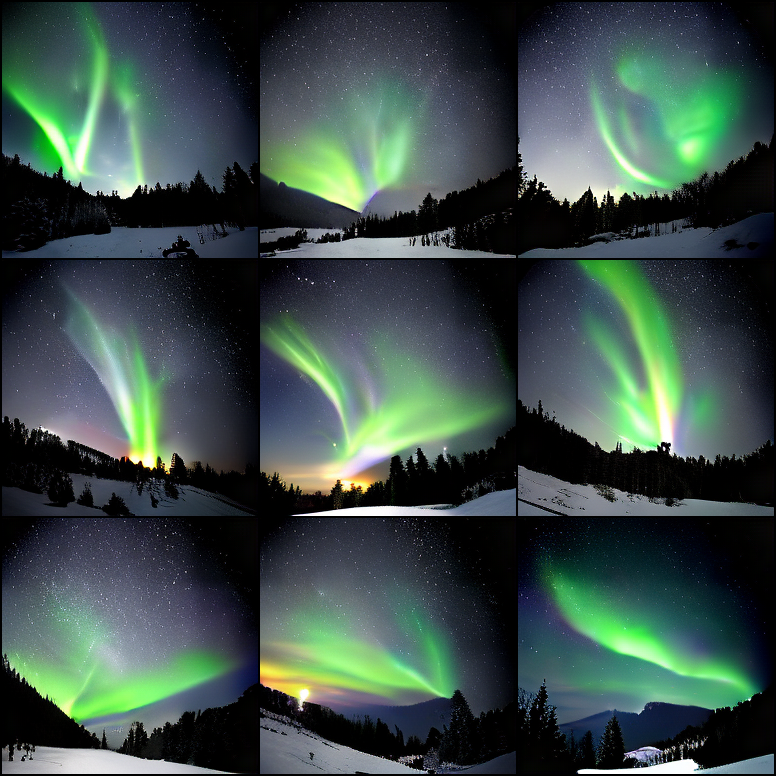

In [45]:
generate("the aurora borealis glowing brightly in a starry night sky above a snowy forest, beautiful stunning photo", negative_prompt="", steps=100, cfg=6, latent_shape=[9, 128, 4, 4])